In [1]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import seaborn as sns

In [3]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [3]:
filepath = '../../../fs_corr_year_data'

### Loading Datasets

In [4]:
test_data_x60 = pd.read_csv(filepath + '/test/60/X_test.csv')
test_data_x60 = test_data_x60.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60 = pd.read_csv(filepath + '/test/60/y_test.csv')
test_data_y60 = test_data_y60.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70 = pd.read_csv(filepath + '/test/70/X_test.csv')
test_data_x70 = test_data_x70.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70 = pd.read_csv(filepath + '/test/70/y_test.csv')
test_data_y70 = test_data_y70.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80 = pd.read_csv(filepath + '/test/80/X_test.csv')
test_data_x80 = test_data_x80.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80 = pd.read_csv(filepath + '/test/80/y_test.csv')
test_data_y80 = test_data_y80.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
validation_60 = {}
validation_70 = {}
validation_80 = {}

for fold in range(0, 5):
    vdata_x60 = pd.read_csv(filepath + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60 = vdata_x60.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60 = pd.read_csv(filepath + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60 = vdata_y60.drop(columns=['Unnamed: 0'], axis=1)
    validation_60[fold] = [vdata_x60, vdata_y60]

    vdata_x70 = pd.read_csv(filepath + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70 = vdata_x70.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70 = pd.read_csv(filepath + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70 = vdata_y70.drop(columns=['Unnamed: 0'], axis=1)
    validation_70[fold] = [vdata_x70, vdata_y70]

    vdata_x80 = pd.read_csv(filepath + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80 = vdata_x80.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80 = pd.read_csv(filepath + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80 = vdata_y80.drop(columns=['Unnamed: 0'], axis=1)
    validation_80[fold] = [vdata_x80, vdata_y80]

In [6]:
train_60 = {}
train_70 = {}
train_80 = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [7]:
for fold in train_60.keys():
    print(train_60[fold][0].shape, train_60[fold][2].shape, train_60[fold][4].shape)

(1590, 68) (2064, 101) (2068, 113)
(1615, 41) (2065, 75) (2070, 113)
(1598, 68) (2062, 101) (2066, 113)
(1618, 41) (2067, 101) (2070, 113)
(1616, 41) (2066, 75) (2070, 113)


In [8]:
for fold in train_70.keys():
    print(train_80[fold][0].shape, train_70[fold][2].shape, train_70[fold][4].shape)

(2068, 1) (2048, 40) (2068, 45)
(2070, 1) (2048, 21) (2070, 45)
(2066, 1) (2045, 40) (2066, 45)
(2070, 1) (2049, 40) (2070, 45)
(2070, 1) (2050, 37) (2070, 45)


In [9]:
for fold in train_80.keys():
    print(train_80[fold][0].shape, train_80[fold][2].shape, train_80[fold][4].shape)

(2068, 1) (2068, 7) (2068, 11)
(2070, 1) (2070, 3) (2070, 11)
(2066, 1) (2066, 7) (2066, 11)
(2070, 1) (2070, 7) (2070, 11)
(2070, 1) (2070, 3) (2070, 11)


In [10]:
import pickle
with open('../../../feature_selection_models/corr_60.pkl', 'rb') as f:
    corr_60 = pickle.load(f)
with open('../../../feature_selection_models/corr_70.pkl', 'rb') as f:
    corr_70 = pickle.load(f)
with open('../../../feature_selection_models/corr_80.pkl', 'rb') as f:
    corr_80 = pickle.load(f)

### Objective Function

In [11]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

##### Code Design

In [ ]:
for corr_idx, corr in enumerate([corr_60, corr_70, corr_80]):
    #for fold in range(0):
        fold = 0
        val_input_data_all_features = validation[fold][0].copy()
        val_input_data = val_input_data_all_features[list(corr)]
        print(corr_idx, val_input_data.shape)
        #val_input_data['setting'] = val_input_data['setting'].astype("category")
        #because lightgbm cannot handle the comma
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        for thresh_idx, thresh in enumerate(['1']):
            if thresh_idx != 0:
                continue
            train_input_data_all_features = train[fold][(thresh_idx+2) * 2].copy()
            train_input_data = train_input_data_all_features[list(corr)]
            #train_input_data['setting'] = train_input_data['setting'].astype("category")
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            train_label = train[fold][(thresh_idx+2) * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            #Create a study object and optimize the objective function.
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
            best_model = lgb.LGBMRegressor(**study.best_params)
            best_model.fit(train_input_data, train_label)
            print(study.best_value)
            print(corr, fold, thresh)

#### Code Implementation

In [12]:
output_dir = '../../../feature_selection_models/by_year/lightgbm'

In [14]:
for corr_idx, corr in enumerate([corr_60, corr_70, corr_80]):
    validation_data = None
    training_data = None
    if corr_idx == 0:
        validation_data = validation_60
        training_data = train_60
    elif corr_idx == 1:
        validation_data = validation_70
        training_data = train_70
    elif corr_idx == 2:
        validation_data = validation_80
        training_data = train_80

    for fold in range(0, 5):
        val_input_data = validation_data[fold][0].copy()
        #because lightgbm cannot handle the comma
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation_data[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        for thresh_idx, thresh in enumerate(['85', '95', '1']):
            train_input_data = training_data[fold][thresh_idx * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh_idx * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            columns_needed = val_input_data.columns.intersection(train_input_data.columns)
            val_relevant_input = val_input_data[columns_needed]

            #Create a study object and optimize the objective function.
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
            best_model = lgb.LGBMRegressor(**study.best_params)
            best_model.fit(train_input_data, train_label)

            corr_name = ''
            if corr_idx == 0:
                corr_name = 'corr_60'
            elif corr_idx == 1:
                corr_name = 'corr_70'
            else: corr_name = 'corr_80'
            
            #save best model 
            joblib.dump(best_model, output_dir + '/best_model_' + corr_name + '_' + str(fold) + '_' + thresh +  '.pkl')
            joblib.dump(study.best_params, f"{output_dir}/best_params_{corr_name}_{fold}_{thresh}.pkl")

            # Save study for later visualization
            joblib.dump(study, f"{output_dir}/optuna_study_{corr_name}_{fold}_{thresh}.pkl")

            summary = {
                "dataset": str(fold) + '_' + thresh,
                "feature selection correlation" : corr_name,
                "fold" : fold,
                "threshold": thresh,
                "model": 'lightgbm',
                "best_params": study.best_params,
                "best_optuna_loss": study.best_value
            }

            with open(f"{output_dir}/results_{corr_name}_{fold}_{thresh}.json", "w") as f:
                json.dump(summary, f, indent=2)

[I 2025-08-10 12:08:50,741] A new study created in memory with name: no-name-212e66de-a0ac-4b17-bb15-b35a49cb4088


[I 2025-08-10 12:08:52,004] Trial 0 finished with value: 4674.976747202805 and parameters: {'number_trees': 75, 'max_tree_depth': 19, 'boosting_type': 'gbdt', 'bagging_fraction': 0.598376186294453, 'bagging_freq': 5, 'learning_rate': 0.30572000527294707, 'l1_norm': 0.0003529605178311928, 'l2_norm': 0.0002283583993063202}. Best is trial 0 with value: 4674.976747202805.
[I 2025-08-10 12:08:53,774] Trial 1 finished with value: 5047.344693737729 and parameters: {'number_trees': 114, 'max_tree_depth': 18, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5009638678606997, 'bagging_freq': 6, 'learning_rate': 0.12859150190688184, 'l1_norm': 0.000526725961231275, 'l2_norm': 0.0002203891211866178}. Best is trial 0 with value: 4674.976747202805.
[I 2025-08-10 12:08:58,852] Trial 2 finished with value: 5737.539351873756 and parameters: {'number_trees': 291, 'max_tree_depth': 20, 'boosting_type': 'gbdt', 'bagging_fraction': 0.7012042530657359, 'bagging_freq': 10, 'learning_rate': 0.2527701269295922, 

### Loading Models

#### Test values for all models

In [ ]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Correlation 0.6', 'Threshold 85%', '1'), ('Correlation 0.6', 'Threshold 85%', '2'), ('Correlation 0.6', 'Threshold 85%', '3'), 
     ('Correlation 0.6', 'Threshold 85%', '4'), ('Correlation 0.6', 'Threshold 85%', '5'), ('Correlation 0.6', 'Threshold 95%', '1'), 
     ('Correlation 0.6', 'Threshold 95%', '2'), ('Correlation 0.6', 'Threshold 95%', '3'), ('Correlation 0.6', 'Threshold 95%', '4'), 
     ('Correlation 0.6', 'Threshold 95%', '5'), ('Correlation 0.6', 'None', '1'), ('Correlation 0.6', 'None', '2'), 
     ('Correlation 0.6', 'None', '3'), ('Correlation 0.6', 'None', '4'), ('Correlation 0.6', 'None', '5'), ('Correlation 0.7', 'Threshold 85%', '1'), 
     ('Correlation 0.7', 'Threshold 85%', '2'), ('Correlation 0.7', 'Threshold 85%', '3'), 
     ('Correlation 0.7', 'Threshold 85%', '4'), ('Correlation 0.7', 'Threshold 85%', '5'), ('Correlation 0.7', 'Threshold 95%', '1'), 
     ('Correlation 0.7', 'Threshold 95%', '2'), ('Correlation 0.7', 'Threshold 95%', '3'), ('Correlation 0.7', 'Threshold 95%', '4'), 
     ('Correlation 0.7', 'Threshold 95%', '5'), ('Correlation 0.7', 'None', '1'), ('Correlation 0.7', 'None', '2'), 
     ('Correlation 0.7', 'None', '3'), ('Correlation 0.7', 'None', '4'), ('Correlation 0.7', 'None', '5'), ('Correlation 0.8', 'Threshold 85%', '1'), 
     ('Correlation 0.8', 'Threshold 85%', '2'), ('Correlation 0.8', 'Threshold 85%', '3'), 
     ('Correlation 0.8', 'Threshold 85%', '4'), ('Correlation 0.8', 'Threshold 85%', '5'), ('Correlation 0.8', 'Threshold 95%', '1'), 
     ('Correlation 0.8', 'Threshold 95%', '2'), ('Correlation 0.8', 'Threshold 95%', '3'), ('Correlation 0.8', 'Threshold 95%', '4'), 
     ('Correlation 0.8', 'Threshold 95%', '5'), ('Correlation 0.8', 'None', '1'), ('Correlation 0.8', 'None', '2'), 
     ('Correlation 0.8', 'None', '3'), ('Correlation 0.8', 'None', '4'), ('Correlation 0.8', 'None', '5')],
    names=['Correlation Subset', 'Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Correlation Subset Missing Data Threshold Fold                         
Correlation 0.6    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
Correlation 0.7    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
Correlation 0.8    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN

In [42]:
best_parameters = {'Correlation 0.6' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}, 
                   'Correlation 0.7' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []},
                   'Correlation 0.8' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}}

In [43]:
for corr_idx, corr in enumerate([corr_60, corr_70, corr_80]):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    else: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            best_params = joblib.load(f"{output_dir}/best_params_{corr_name}_{fold}_{name}.pkl")
            best_parameters[table_corr_name][thresh_name].append(best_params)

            train_input_data = training_data[fold][thresh_idx * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh_idx * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            columns_needed = testing_datax.columns.intersection(train_input_data.columns)
            to_test = testing_datax[columns_needed].copy()

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_66767/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_66767/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_66767/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [44]:
test_stats

MAPE        MAE  \
Correlation Subset Missing Data Threshold Fold                        
Correlation 0.6    Threshold 85%          1     0.456407  27.163755   
                                          2      0.45113  27.078181   
                                          3     0.506383  29.825128   
                                          4     0.432331  27.949383   
                                          5     0.446039  26.602592   
                   Threshold 95%          1     0.436401   28.02073   
                                          2     0.426357  28.819246   
                                          3     0.492627  28.050405   
                                          4     0.477862  31.743148   
                                          5     0.472657  29.368022   
                   None                   1      0.42555  27.813047   
                                          2     0.433355  26.309657   
                                          3     0.591554  36.702238   
                                          4     0.460562  28.850251   
                                          5     0.460196  31.625117   
Correlation 0.7    Threshold 85%          1     0.490368  35.719401   
                                          2     0.448882  33.676109   
                                          3     0.448992  33.902535   
                                          4     0.493295  35.264941   
                                          5     0.499592  34.923832   
                   Threshold 95%          1      0.42523  34.065345   
                                          2     0.567783  35.408095   
                                          3     0.494506  34.500909   
                                          4     0.486587  34.455916   
                                          5     0.562451  37.707064   
                   None                   1      0.43477  35.347344   
                                          2     0.509664  35.286837   
                                          3     0.485291  34.178982   
                                          4     0.466986   32.66566   
                                          5     0.522058  35.486932   
Correlation 0.8    Threshold 85%          1     0.636847  61.901582   
                                          2     0.630754  60.416097   
                                          3     0.686689  66.620129   
                                          4     0.614123  58.749998   
                                          5     0.756857  67.456451   
                   Threshold 95%          1     0.606142  58.887192   
                                          2     0.659627  61.566571   
                                          3     0.643479   61.38474   
                                          4     0.585162  58.436521   
                                          5     0.693791  61.782284   
                   None                   1     0.603488  58.278202   
                                          2     0.626521  60.044091   
                                          3     0.654974  63.900238   
                                          4     0.633506  60.965701   
                                          5     0.682093  59.349653   

                                                         MSE        RMSE  \
Correlation Subset Missing Data Threshold Fold                             
Correlation 0.6    Threshold 85%          1       5008.94654   70.773911   
                                          2      4523.374376   67.256036   
                                          3      5951.215073   77.144119   
                                          4      5969.769796   77.264285   
                                          5      4955.476102   70.395143   
                   Threshold 95%          1       5985.24204   77.364346   
                                          2      6167.076083   78.530733   
                              

In [45]:
mean_summary = test_stats.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

#### Best Parameters

#### Visualisation

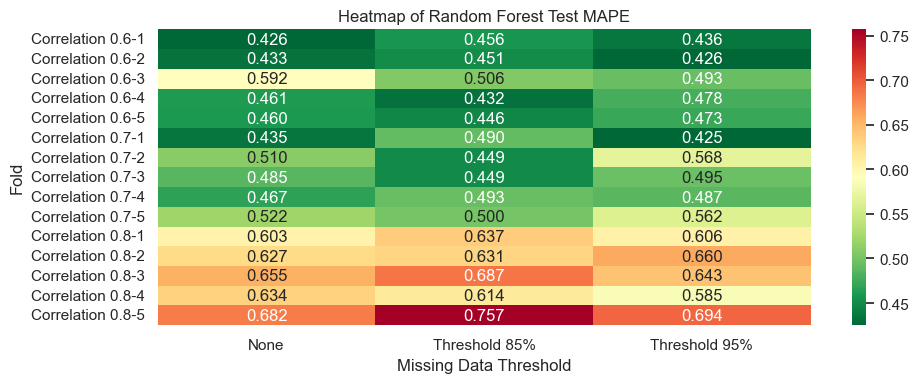

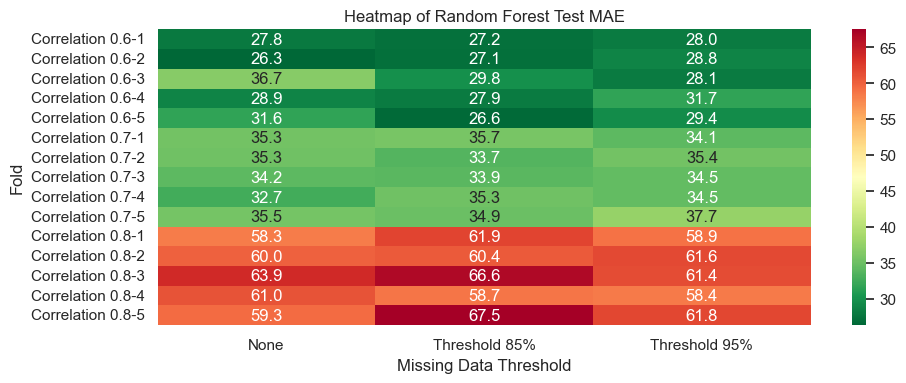

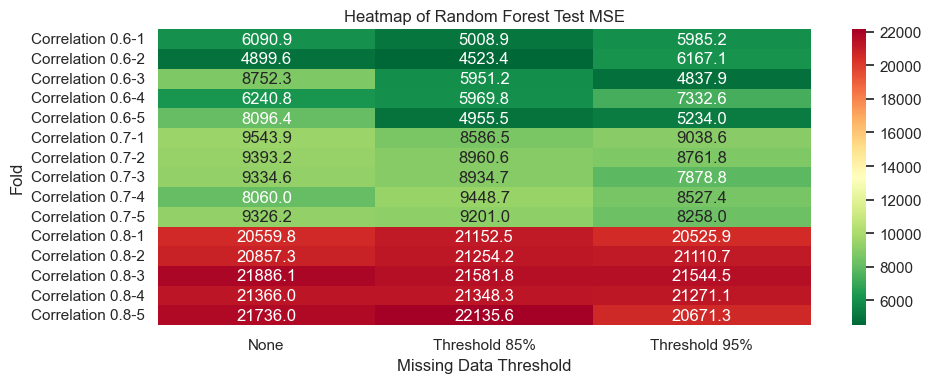

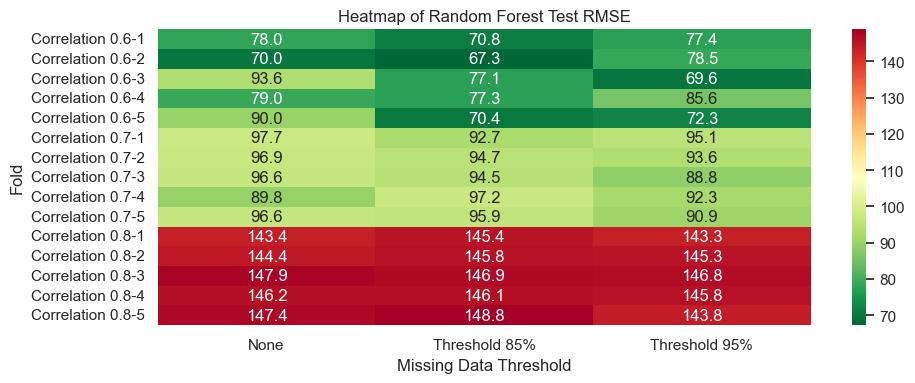

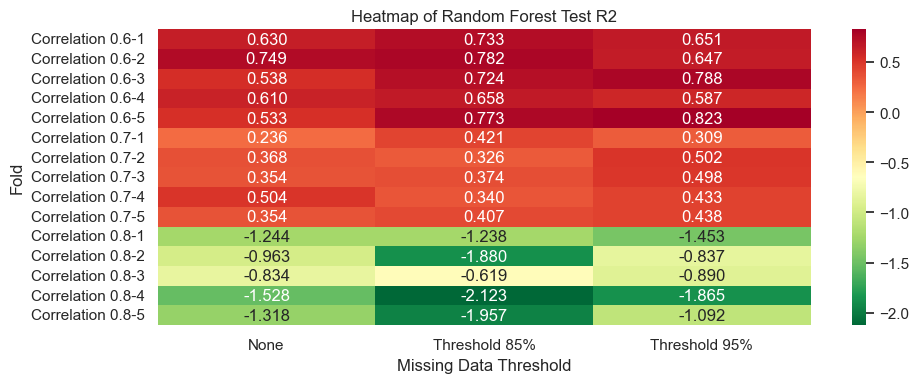

In [46]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [48]:
mean_original = joblib.load('../../../split_year_models/base_mean_metrics.pkl')
std_original = joblib.load('../../../split_year_models/base_std_metrics.pkl')

In [49]:
no_corr_df = mean_original['LightGBM']
no_corr_df['Correlation Subset'] = 'No Correlation'
no_corr_df.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df = no_corr_df.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
no_corr_df

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_66767/2733510745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df['Correlation Subset'] = 'No Correlation'


Metric                                     MAPE    MAE      MSE   RMSE    R2
Correlation Subset Missing Data Threshold                                   
No Correlation     None                    0.47  29.64  5945.48  77.08  0.81
                   Threshold 85%           0.50  31.14  7254.13  85.03  0.77
                   Threshold 95%           0.40  25.50  5672.85  75.24  0.82

In [50]:
all_data = pd.concat([mean_summary, no_corr_df])
all_data

MAPE    MAE       MSE    RMSE    R2
Correlation Subset Missing Data Threshold                                     
Correlation 0.6    None                    0.47  30.26   6816.00   82.11  0.61
                   Threshold 85%           0.46  27.72   5281.76   72.57  0.73
                   Threshold 95%           0.46  29.20   5911.35   76.69  0.70
Correlation 0.7    None                    0.48  34.59   9131.59   95.52  0.36
                   Threshold 85%           0.48  34.70   9026.29   94.99  0.37
                   Threshold 95%           0.51  35.23   8492.91   92.13  0.44
Correlation 0.8    None                    0.64  60.51  21281.06  145.87 -1.18
                   Threshold 85%           0.67  63.03  21494.47  146.61 -1.56
                   Threshold 95%           0.64  60.41  21024.69  144.99 -1.23
No Correlation     None                    0.47  29.64   5945.48   77.08  0.81
                   Threshold 85%           0.50  31.14   7254.13   85.03  0.77
                   Threshold 95%           0.40  25.50   5672.85   75.24  0.82

In [51]:
no_corr_std = std_original['LightGBM']
no_corr_std['Correlation Subset'] = 'No Correlation'
no_corr_std.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std = no_corr_std.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data = pd.concat([std_summary, no_corr_std])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_66767/1621931639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std['Correlation Subset'] = 'No Correlation'


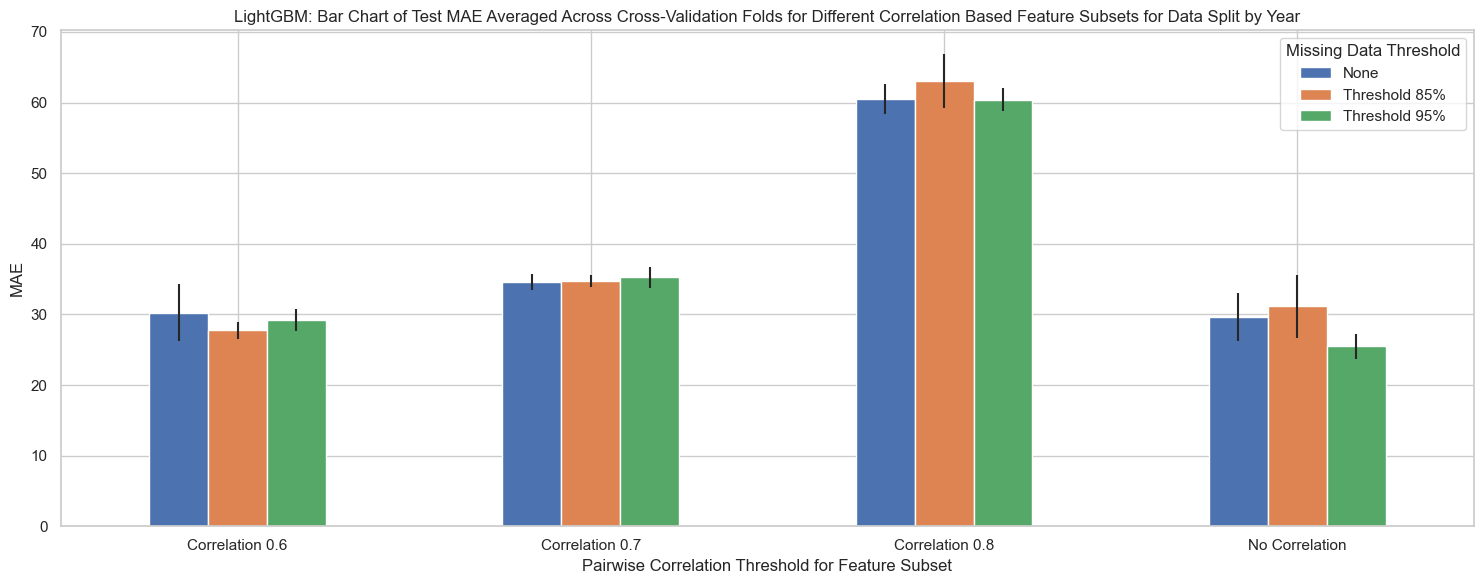

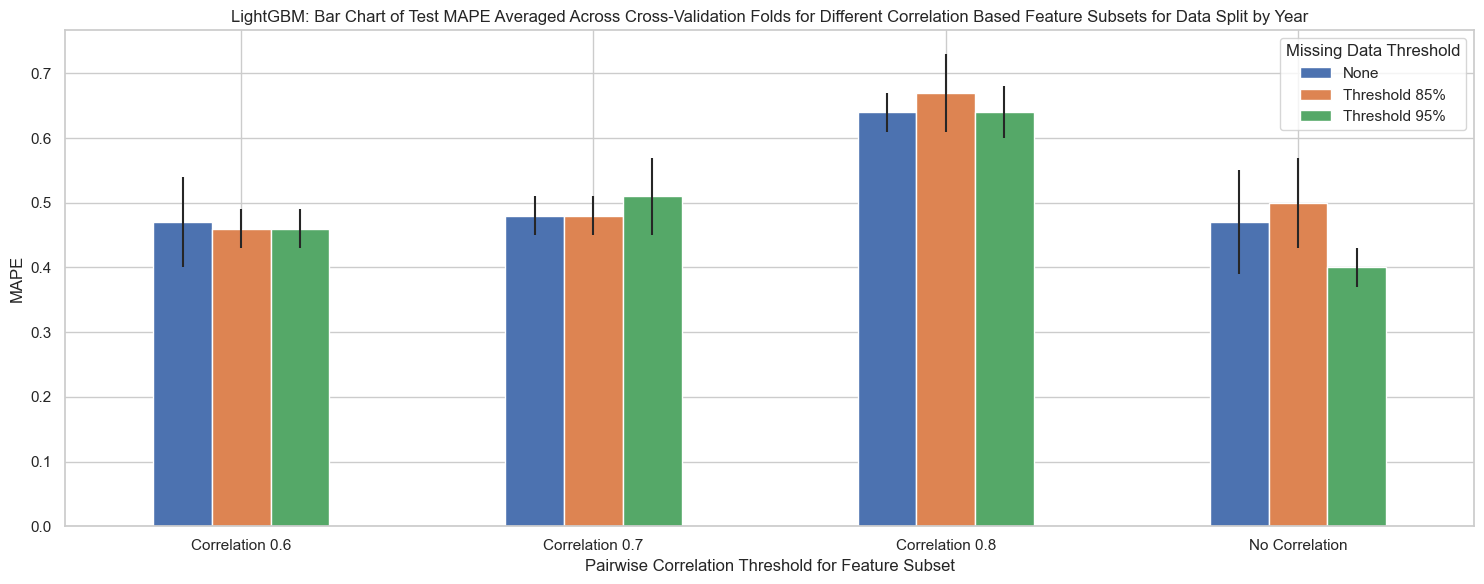

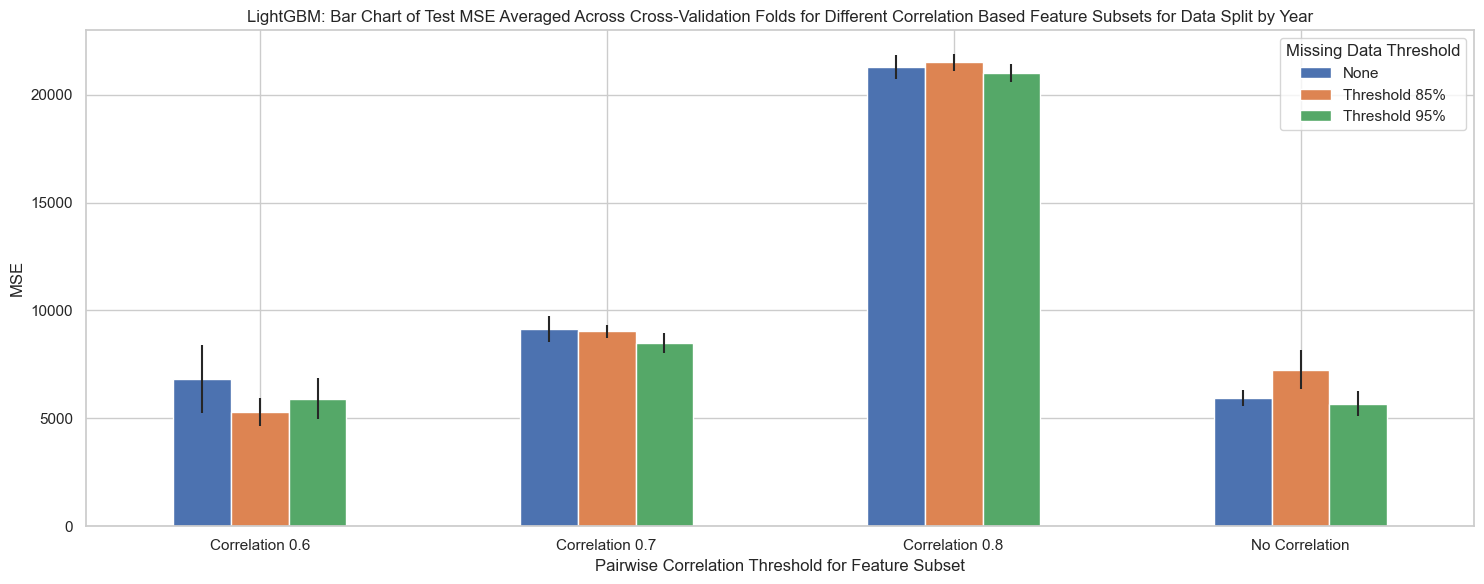

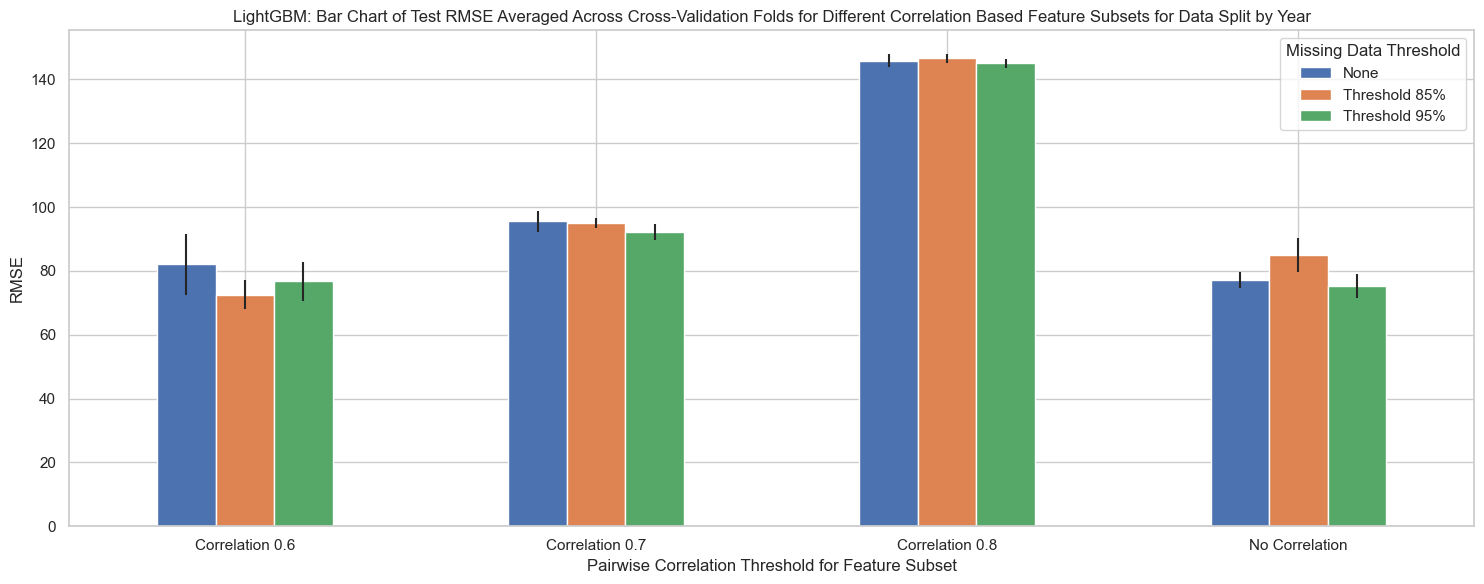

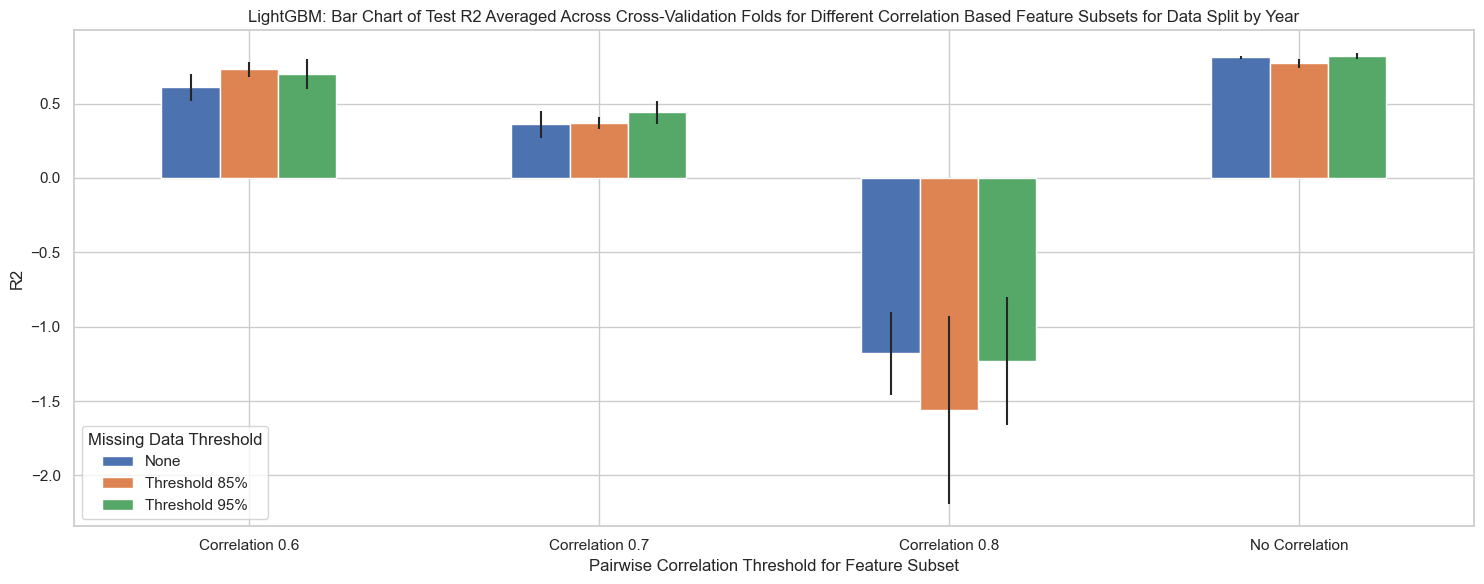

In [52]:
mean_data = all_data.astype(float)
std_data = all_std_data.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Year")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()